# Introducción al Aprendizaje por Refuerzos III
## Nicolás Salusso - 10710

### 1.1 - Modificación de la implementación de Q-Learning realizada en el TP 8, para integrar aprendizaje basado en modelos (Dyna-Q).

#### Definición del modelo

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import random

# tamaño del entorno (Alto)
WORLD_HEIGHT = 7

# tamaño del entorno (Ancho)
WORLD_WIDTH = 10

# Fuerza del viento para cada columna
WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

# Acciones posibles
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3

# probabilidad de exploración
EPSILON = 0.1

# Learning rate
ALPHA = 0.5

# reward
REWARD = -1.0

# valor de los pares estado acción
stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
startState = [3, 0]
goalState = [3, 7]
actions = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]


# Model (s, a)
model_R = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
model_S_i = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
model_S_j = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))

# transiciones de estado
actionDestination = []
for i in range(0, WORLD_HEIGHT):
    actionDestination.append([])
    for j in range(0, WORLD_WIDTH):
        destination = dict()
        destination[ACTION_UP] = [max(i - 1 - WIND[j], 0), j]
        destination[ACTION_DOWN] = [max(min(i + 1 - WIND[j], WORLD_HEIGHT - 1), 0), j]
        destination[ACTION_LEFT] = [max(i - WIND[j], 0), max(j - 1, 0)]
        destination[ACTION_RIGHT] = [max(i - WIND[j], 0), min(j + 1, WORLD_WIDTH - 1)]
        actionDestination[-1].append(destination)

#### Función de iteración en un episodio

In [2]:
def oneEpisode():
    
    # acumulador de steps en el episodio
    time = 0

    # estado inicial
    currentState = startState
    
    # Función que selecciona la acción basada en epsilon-greedy
    def accion_por_politica():
        if np.random.binomial(1, EPSILON) == 1:
            accion = np.random.choice(actions)
        else:
            accion = np.argmax(stateActionValues[currentState[0], currentState[1], :])
        return accion
        

    # selección de acción basada en epsilon-greedy
    currentAction = accion_por_politica()

    # interactuar hasta arribar al estado objetivo
    while currentState != goalState:
        newState = actionDestination[currentState[0]][currentState[1]][currentAction]
        
        max_action = np.argmax(stateActionValues[newState[0], newState[1], :])
        
        stateActionValues[currentState[0], currentState[1], currentAction] += \
            ALPHA * (REWARD + stateActionValues[newState[0], newState[1], max_action] -
            stateActionValues[currentState[0], currentState[1], currentAction])
        
        model_R[currentState[0], currentState[1], currentAction] = REWARD
        model_S_i[currentState[0], currentState[1], currentAction] = newState[0]
        model_S_j[currentState[0], currentState[1], currentAction] = newState[1]
        
        for n in range(0, 20):
            state = []
            state.append([])
            state.append([])
            state[0] = random.randint(0, WORLD_HEIGHT - 1)
            state[1] = random.randint(0, WORLD_WIDTH - 1)
            accion = np.random.choice(actions)
            r = model_R[state[0], state[1], accion]
            s_prima_i = int(model_S_i[state[0], state[1], accion])
            s_prima_j = int(model_S_j[state[0], state[1], accion])
            
            max_action = np.argmax(stateActionValues[s_prima_i, s_prima_j, :])
            
            stateActionValues[state[0], state[1], accion] += \
            ALPHA * (r + stateActionValues[s_prima_i, s_prima_j, max_action] -
            stateActionValues[state[0], state[1], accion])
            
        currentState = newState
        currentAction = accion_por_politica()
        
        time += 1
    return time

#### Ejecución de los 500 episodios y obtención de política óptima y gráfica.

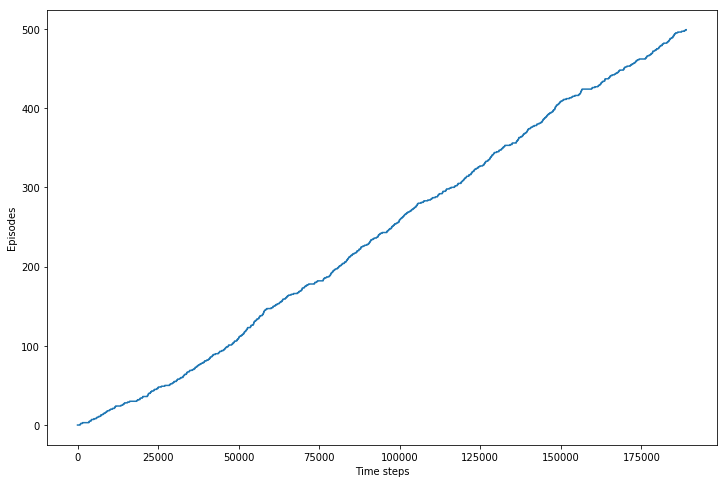

['D', 'D', 'D', 'L', 'L', 'L', 'L', 'D', 'L', 'U']
['U', 'U', 'D', 'L', 'D', 'D', 'L', 'R', 'L', 'R']
['D', 'L', 'L', 'R', 'D', 'L', 'R', 'D', 'D', 'U']
['D', 'D', 'L', 'L', 'U', 'L', 'L', 'G', 'L', 'D']
['D', 'U', 'L', 'R', 'U', 'D', 'D', 'D', 'L', 'L']
['D', 'U', 'D', 'D', 'R', 'U', 'D', 'D', 'L', 'U']
['U', 'R', 'D', 'D', 'U', 'D', 'R', 'R', 'U', 'U']
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


In [3]:
# Cantidad de episodios
episodeLimit = 500
ep = 0
episodes_dyna_q = []
time = 0
time_acum = 0
grafica_dyna_q = []
while ep < episodeLimit:
    time = oneEpisode()
    episodes_dyna_q.extend([ep] * time)
    time_acum += time
    grafica_dyna_q.append(time_acum/(ep + 1))
    ep += 1

plt.figure(figsize=(12, 8))
plt.plot(episodes_dyna_q)
plt.xlabel('Time steps')
plt.ylabel('Episodes')
plt.show()

# Selección Greedy sobre la política...
optimalPolicyDynaQ = []
for i in range(0, WORLD_HEIGHT):
    optimalPolicyDynaQ.append([])
    for j in range(0, WORLD_WIDTH):
        if [i, j] == goalState:
            optimalPolicyDynaQ[-1].append('G')
            continue
        bestAction = np.argmax(stateActionValues[i, j, :])
        if bestAction == ACTION_UP:
            optimalPolicyDynaQ[-1].append('U')
        elif bestAction == ACTION_DOWN:
            optimalPolicyDynaQ[-1].append('D')
        elif bestAction == ACTION_LEFT:
            optimalPolicyDynaQ[-1].append('L')
        elif bestAction == ACTION_RIGHT:
            optimalPolicyDynaQ[-1].append('R')
for row in optimalPolicyDynaQ:
    print(row)
print([str(w) for w in WIND])

### 1.2 - Comparación de la convergencia de la implementación basada en $Sarsa(\lambda)$, respecto a la implementación de Dyna-Q empleando una gráfica de Steps Acumulados Promedio vs. Episodio.

#### $Sarsa(\lambda)$

#### Definición del modelo

In [4]:
from __future__ import print_function
import numpy as np
# from python_utils.import_ import import_global
import matplotlib.pyplot as plt


# tamaño del entorno (Alto)
WORLD_HEIGHT = 7

# tamaño del entorno (Ancho)
WORLD_WIDTH = 10

# Fuerza del viento para cada columna
WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

# Acciones posibles
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3

# probabilidad de exploración
EPSILON = 0.1

# Learning rate
ALPHA = 0.5

# reward
REWARD = -1.0

# valor de los pares estado acción
stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
startState = [3, 0]
goalState = [3, 7]
actions = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

# transiciones de estado
actionDestination = []
for i in range(0, WORLD_HEIGHT):
    actionDestination.append([])
    for j in range(0, WORLD_WIDTH):
        destination = dict()
        destination[ACTION_UP] = [max(i - 1 - WIND[j], 0), j]
        destination[ACTION_DOWN] = [max(min(i + 1 - WIND[j], WORLD_HEIGHT - 1), 0), j]
        destination[ACTION_LEFT] = [max(i - WIND[j], 0), max(j - 1, 0)]
        destination[ACTION_RIGHT] = [max(i - WIND[j], 0), min(j + 1, WORLD_WIDTH - 1)]
        actionDestination[-1].append(destination)

# LAMBDA
LAMBDA = 0.8

# Traza
e = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))

#### Función de iteración en un episodio

In [5]:
# interacción en un episodio
def oneEpisode():
    # acumulador de steps en el episodio
    time = 0

    # estado inicial
    currentState = startState

    # selección de acción basade en epsilon-greedy
    if np.random.binomial(1, EPSILON) == 1:
        currentAction = np.random.choice(actions)
    else:
        currentAction = np.argmax(stateActionValues[currentState[0], currentState[1], :])

    # interactuar hasta arribar al estado objetivo
    while currentState != goalState:
        newState = actionDestination[currentState[0]][currentState[1]][currentAction]
        if np.random.binomial(1, EPSILON) == 1:
            newAction = np.random.choice(actions)
        else:
            newAction = np.argmax(stateActionValues[newState[0], newState[1], :])
            
        # Sarsa(lambda) update
        
        # Se define delta
        delta = (REWARD + stateActionValues[newState[0], newState[1], newAction] -
            stateActionValues[currentState[0], currentState[1], currentAction])
        
        # Se actualiza la traza en el estado que se paso.
        e[currentState[0], currentState[1], currentAction] += 1
        
        for i in range(0, WORLD_HEIGHT):
            for j in range(0, WORLD_WIDTH):
                for action in actions:
                    stateActionValues[i, j, action] += ALPHA * delta * e[i, j, action]
                    e[i, j, action] = LAMBDA * e[i, j, action]

        currentState = newState
        currentAction = newAction
        time += 1
    return time

#### Ejecución de los 500 episodios.

In [6]:
# Cantidad de episodios

episodeLimit = 500
ep = 0
episodes_graf_sarsa_lambda = []
time = 0
time_acum = 0
grafica_sarsa_lambda = []
while ep < episodeLimit:
    time = oneEpisode()
    episodes_graf_sarsa_lambda.extend([ep] * time)
    time_acum += time
    grafica_sarsa_lambda.append(time_acum/(ep + 1))
    ep += 1

### Comparación

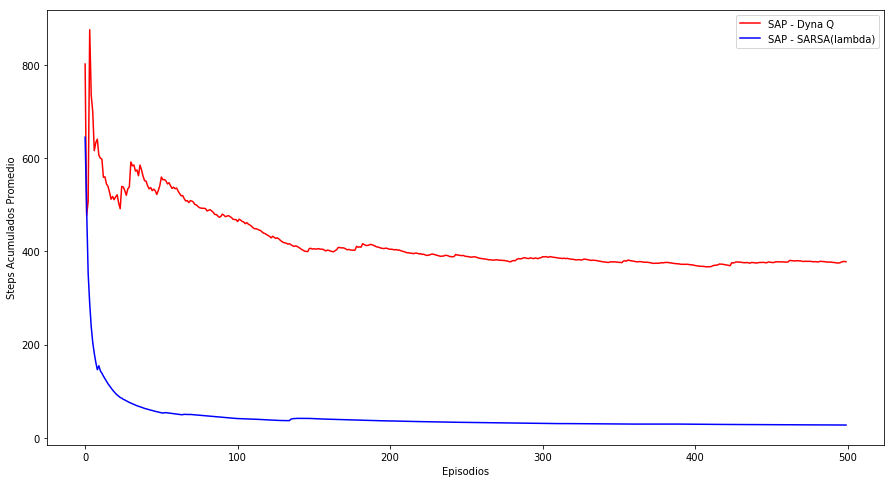

SAP = Steps Acumulados Promedio


In [7]:
plt.figure(figsize=(15, 8))
dyna_q = plt.plot(grafica_dyna_q, 'r-', label='SAP - Dyna Q')
sarsa_lambda = plt.plot(grafica_sarsa_lambda, 'b-', label='SAP - SARSA(lambda)')
plt.legend()
plt.xlabel('Episodios')
plt.ylabel('Steps Acumulados Promedio')
plt.show()

print('SAP = Steps Acumulados Promedio')